In [19]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# 1. Daten laden (Stelle sicher, dass der Pfad stimmt)
df = pd.read_csv('../clean_data/SP500_Cleaned.csv', index_col='Date', parse_dates=True)

# 2. Feature Engineering (Wir geben dem Modell "Augen")
# Gleitende Durchschnitte
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Relative Stärke (Abstand zum Durchschnitt)
df['Dist_MA20'] = df['Close'] / df['MA20'] - 1

# Volatilität (Standardabweichung der letzten 10 Tage)
df['Volatility'] = df['Change_Percent'].rolling(window=10).std()

In [21]:
# 3. Target Variable erstellen (Das Ziel)
# Wir schauen 5 Tage in die Zukunft
days_ahead = 5
df['Future_Close'] = df['Close'].shift(-days_ahead)
df['Future_Return'] = (df['Future_Close'] - df['Close']) / df['Close'] * 100

# Definition: BUY (1) wenn Gewinn > 1%, sonst NO BUY (0)
df['Target'] = np.where(df['Future_Return'] > 1.0, 1, 0)

# Zeilen mit NaN entfernen (entstehen durch gleitende Fenster und Shift)
df_ml = df.dropna().copy()

In [22]:
# 4. Features und Target definieren
features = ['Open', 'High', 'Low', 'Close', 'Change_Percent', 'MA20', 'MA50', 'Dist_MA20', 'Volatility']
X = df_ml[features]
y = df_ml['Target']

# 5. Zeitreihen-Split (Kein Random Shuffle, da Zeitreihen!)
split_point = int(len(df_ml) * 0.7)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

In [23]:
# 6. Modell trainieren (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

--- MODELL PERFORMANCE ---
Genauigkeit (Accuracy): 0.56

--- Klassifikationsbericht ---
              precision    recall  f1-score   support

           0       0.60      0.81      0.69       129
           1       0.34      0.16      0.22        81

    accuracy                           0.56       210
   macro avg       0.47      0.48      0.45       210
weighted avg       0.50      0.56      0.51       210



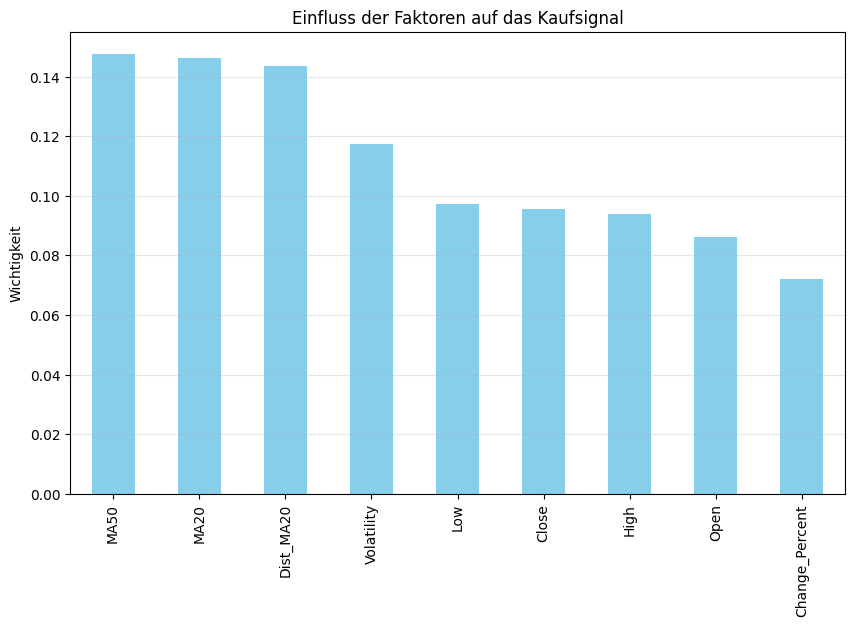

In [25]:
# 7. Vorhersagen treffen
y_pred = model.predict(X_test)

# 8. Evaluation ausgeben
print("--- MODELL PERFORMANCE ---")
print(f"Genauigkeit (Accuracy): {accuracy_score(y_test, y_pred):.2f}")
print("\n--- Klassifikationsbericht ---")
print(classification_report(y_test, y_pred))

# 9. Wichtigkeit der Features visualisieren
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='bar', color='skyblue')
plt.title('Einfluss der Faktoren auf das Kaufsignal')
plt.ylabel('Wichtigkeit')
plt.grid(axis='y', alpha = 0.3)
plt.savefig('../data_visualization(week 8)/visualized_data/4_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()